# 1. IMPORTING PYTHON LIBRARIES

In [132]:
import requests
import json
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import pymongo
import base64

# 2. EXTRACTING, TRANFORMING AND LOADING DATA FROM DATABASE

The database was downloaded from Kaggle using the following link:

https://www.kaggle.com/laudanum/footballdelphi

In [2]:
conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()

In the next cell an SQL query is used to extract the data we want from the database. This is theen turned into a pandas dataframe that we can work with.

In [3]:
cur.execute("""SELECT Match_ID, TeamName, HomeTeam, AwayTeam, Date, Season, Div, 
                FTHG AS HomeTeamGoals, FTAG AS AwayTeamGoals, FTR AS Winners
                FROM Matches
                JOIN Teams_in_Matches
                USING (Match_ID)
                JOIN Unique_Teams
                USING (Unique_Team_ID)
                WHERE Season = 2011
                ;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Match_ID,TeamName,HomeTeam,AwayTeam,Date,Season,Div,HomeTeamGoals,AwayTeamGoals,Winners
0,1092,Bayern Munich,Nurnberg,Bayern Munich,2012-03-31,2011,D1,0,1,A
1,1092,Nurnberg,Nurnberg,Bayern Munich,2012-03-31,2011,D1,0,1,A
2,1093,Bayern Munich,Stuttgart,Bayern Munich,2011-12-11,2011,D1,1,2,A
3,1093,Stuttgart,Stuttgart,Bayern Munich,2011-12-11,2011,D1,1,2,A
4,1094,Bayern Munich,Wolfsburg,Bayern Munich,2011-08-13,2011,D1,0,1,A


In the preview of the cell above it can be seen that there are two rows per game (one rown for each of the teams playing in that particular game). The 'Winners' column is populated with A or H which is referring to whether the home team or away team won that game.

The database contains both German (Division = D1 or D2) and English (Division = E0) teams. For this analysis we are only interested in the German teams within the database so all teams that are not in the German divisions are removed.

In [50]:
all_games = len(df)/2
non_German_div_index = df[df['Div'] == "E0" ].index
df.drop(non_German_div_index , inplace=True)
german_games = len(df)/2
print("{} games removed!".format(int(all_games - german_games)))

0 games removed!


The following cell determines whether a team won or loss based on the TeamName column value and the Winners column value.

In [5]:
for i, row in df.iterrows():
    if row.TeamName == row.AwayTeam:
        if row.Winners == 'A':
            df.loc[i, 'Result'] = 'W'
        if row.Winners == 'D':
            df.loc[i, 'Result'] = 'D'
        if row.Winners == 'H':
            df.loc[i, 'Result'] = 'L'
    else:
        if row.Winners == 'H':
            df.loc[i, 'Result'] = 'W'
        if row.Winners == 'D':
            df.loc[i, 'Result'] = 'D'
        if row.Winners == 'A':
            df.loc[i, 'Result'] = 'L'

In [6]:
df.head()

,Match_ID,TeamName,HomeTeam,AwayTeam,Date,Season,Div,HomeTeamGoals,AwayTeamGoals,Winners,Result
0,1092,Bayern Munich,Nurnberg,Bayern Munich,2012-03-31,2011,D1,0,1,A,W
1,1092,Nurnberg,Nurnberg,Bayern Munich,2012-03-31,2011,D1,0,1,A,L
2,1093,Bayern Munich,Stuttgart,Bayern Munich,2011-12-11,2011,D1,1,2,A,W
3,1093,Stuttgart,Stuttgart,Bayern Munich,2011-12-11,2011,D1,1,2,A,L
4,1094,Bayern Munich,Wolfsburg,Bayern Munich,2011-08-13,2011,D1,0,1,A,W


As can be seen from the preview above, we now have a Win or Loss result for each team and match in the dataframe.

The cell below is simply making a copy of the dataframe at this point to be used for the weather analysis that occurs later on.

In [7]:
df_weather = df

Next we need to determine how many goals the team scored in the game.  This is done by checking whether the team playing is the home or away team, and then using the values HomeTeamGoals or AwayTeamGoals columns accordingly.

In [8]:
for i, row in df.iterrows():
    if row.TeamName == row.AwayTeam:
        df.loc[i, 'GoalsScored'] = df.loc[i, 'AwayTeamGoals']
    elif row.TeamName == row.HomeTeam:
        df.loc[i, 'GoalsScored'] = df.loc[i, 'HomeTeamGoals']

In [9]:
df.head()

,Match_ID,TeamName,HomeTeam,AwayTeam,Date,Season,Div,HomeTeamGoals,AwayTeamGoals,Winners,Result,GoalsScored
0,1092,Bayern Munich,Nurnberg,Bayern Munich,2012-03-31,2011,D1,0,1,A,W,1.0
1,1092,Nurnberg,Nurnberg,Bayern Munich,2012-03-31,2011,D1,0,1,A,L,0.0
2,1093,Bayern Munich,Stuttgart,Bayern Munich,2011-12-11,2011,D1,1,2,A,W,2.0
3,1093,Stuttgart,Stuttgart,Bayern Munich,2011-12-11,2011,D1,1,2,A,L,1.0
4,1094,Bayern Munich,Wolfsburg,Bayern Munich,2011-08-13,2011,D1,0,1,A,W,1.0


The total goals scored by the team in the 2011 season must be summed. This is achieved by completing a pivot of the table where the aggregate function is 'sum'. The columns that are no longer needed are dropped from the dataframe. The index is then reset to get the headers as desired. The values in the total goals column are then turned into integers.

In [51]:
total_goals_scored = df.pivot_table(index = 'TeamName', aggfunc='sum')
total_goals_scored = total_goals_scored.rename(columns={"GoalsScored":"Total Goals Scored (2011 Season)"})
total_goals_scored = total_goals_scored.drop(columns = ['AwayTeamGoals','HomeTeamGoals','Match_ID','Season'])
total_goals_scored = total_goals_scored.reset_index()
total_goals_scored['Total Goals Scored (2011 Season)'] = total_goals_scored['Total Goals Scored (2011 Season)'].astype(int)
total_goals_scored.head()

,TeamName,Total Goals Scored (2011 Season)
0,Aachen,6.0
1,Augsburg,9.0
2,Bayern Munich,15.0
3,Bochum,6.0
4,Braunschweig,11.0


A pivot is also required to get the total wins, draws and losses of each team for the season. This time the aggregate function is 'count' as we are counting the number of times a 'W', 'L' or 'D' occurs in the Result column.

In [11]:
wins_and_losses = df.pivot_table(df, index = 'TeamName', columns=['Result'], aggfunc='count')
wins_and_losses = wins_and_losses.drop(columns = ['AwayTeam', 'AwayTeamGoals', 'Date', 'Div','HomeTeamGoals','Match_ID','Season','GoalsScored','HomeTeam'])
wins_and_losses.head()

Winners        
Result              D   L   W
TeamName                     
Aachen             13  15   6
Augsburg           14  12   8
Bayern Munich       4   7  23
Bochum              7  17  10
Braunschweig       15   9  10

After the pivot, the headers of the table are not as desired, therefore the following cell changes the header positions and resets the index. As can be seen from the preview, the dataframe columns are as they should be now.

In [12]:
wins_and_losses.columns = [col[1] for col in wins_and_losses.columns]
wins_and_losses.reset_index(inplace=True)
wins_and_losses.head(1)

,TeamName,D,L,W
0,Aachen,13,15,6


Next the total_goals_scored dataframe and the wins_and_losses dataframe must be concatenated so that all of the information is in the same dataframe. When doing this the TeamName column is repeated as it exists in both dataframes. Because of this we need to eliminate all duplicate columns.

In [13]:
team_data = pd.concat([total_goals_scored, wins_and_losses], axis=1)
team_data = team_data.loc[:,~team_data.columns.duplicated()] # the ~ inverts the boolean statement from team_data.columns.duplicated() because wewant to keep non-duplicates
team_data.head()

,TeamName,Total Goals Scored (2011 Season),D,L,W
0,Aachen,30.0,13,15,6
1,Augsburg,36.0,14,12,8
2,Bayern Munich,77.0,4,7,23
3,Bochum,41.0,7,17,10
4,Braunschweig,37.0,15,9,10


For the weather analysis we needed another dataframe from the database that only had one row per game. This was so that we remained below the DarkSky API request limits. The cell below contains a SQL query extracting the data that we need. It is then converted into a pandas dataframe and all non-German teams are once again removed.

**THESE CELLS SHOULD NEVER BE RUN MORE THAN ONCE AS THEY WILL RESET THE APIWORK COMPLETED LATER IN THE NOTEBOOK!**

In [14]:
# cur.execute("""SELECT *
#                 FROM Matches
#                 WHERE Season = 2011
#                 ;""")
# df_2 = pd.DataFrame(cur.fetchall())
# df_2.columns = [x[0] for x in cur.description]
# df_2.head()

In [16]:
# non_German_div_index = df_2[df_2['Div'] == "E0" ].index
# df_2.drop(non_German_div_index , inplace=True)

# 3. DARKSKY API

The API key for DarkSky is stored locally, therefore the following function is used to locate the file on the computer.

In [52]:
def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [53]:
keys = get_keys("/Users/ravimalde/.secret/dark_sky_api_2.json")
api_key = keys['api_key']

The latitude and longitude of Berlin are used for this analysis. An arbitrary date and time are for the initial contact with the API.

In [54]:
latitude = 52.5200
longitude = 13.4050

date = "2020-01-30"
url = "https://api.darksky.net/forecast/{}/{},{},{}T16:00:00".format(api_key, latitude, longitude, date)
r = requests.get(url)

To determine the layout of the json file response from the API, the dictionary keys are printed out below. These keys were each explored and it was decided that the 'daily' key would provide us with the most relevant information as we are looking for whether or not it rained on a given day.

In [56]:
r.json().keys()

dict_keys(['latitude', 'longitude', 'timezone', 'currently', 'hourly', 'daily', 'flags', 'offset'])

The 'icon' key within 'daily' conatins the application icon that was displayed on a given day. If it rained on a day then this would simply be a 'rain' icon. This was far simpler that the 'summary' key which gave a one line descriptive sentence of the weather that day. 

In [58]:
r.json()['daily']

{'data': [{'time': 1580338800,
   'summary': 'Light rain until afternoon, starting again overnight.',
   'icon': 'rain',
   'sunriseTime': 1580367180,
   'sunsetTime': 1580399280,
   'moonPhase': 0.18,
   'precipIntensity': 0.0072,
   'precipIntensityMax': 0.0338,
   'precipIntensityMaxTime': 1580374380,
   'precipProbability': 0.79,
   'precipType': 'rain',
   'temperatureHigh': 47.7,
   'temperatureHighTime': 1580390580,
   'temperatureLow': 41.41,
   'temperatureLowTime': 1580417160,
   'apparentTemperatureHigh': 41.15,
   'apparentTemperatureHighTime': 1580390580,
   'apparentTemperatureLow': 35.35,
   'apparentTemperatureLowTime': 1580418540,
   'dewPoint': 37.64,
   'humidity': 0.86,
   'pressure': 1006.8,
   'windSpeed': 13.48,
   'windGust': 34.6,
   'windGustTime': 1580368080,
   'windBearing': 237,
   'cloudCover': 0.93,
   'uvIndex': 1,
   'uvIndexTime': 1580383440,
   'visibility': 10,
   'ozone': 339.1,
   'temperatureMin': 37.12,
   'temperatureMinTime': 1580349600,
   't

The cell below is where a request is sent to the DarkSky API for each row within the dataframe. The weather for the game is then added to a new 'Weather' column.

**THE COMMENTED CELL SHOULD NOT BE RUN AGAIN DUE TO API REQUEST LIMITS!**

In [64]:
# latitude = 52.5200
# longitude = 13.4050

# for i, row in df_2.iterrows():
    
#     date = df_2.loc[i, 'Date']
#     url = "https://api.darksky.net/forecast/{}/{},{},{}T16:00:00".format(api_key, latitude, longitude, date)
#     r = requests.get(url)
#     weather_summary = r.json()['daily']['data'][0].get("icon", "clear")
#     df_2.loc[i, 'Weather'] = weather_summary

In [63]:
df_2.head()

NameError: name 'df_2' is not defined

As can be seen from the dataframe summary above, the weather for each of the match days has been added to a new column.

The cell below is where the dataframe with weather is saved as a .csv file. This was done as a safety measure in case the dataframe was accidentally overwritten and the weather information was lost.

In [61]:
# df_2.to_csv("matches_with_weather.csv")

# 4. CALCULATION OF WIN % DURING RAINY GAMES

A new dataframe of all the matches with the weatehr . for the day is created by reading in the .csv file saved in the cells above.

In [18]:
df_matches_with_weather = pd.read_csv("matches_with_weather.csv")

In [19]:
df_matches_with_weather.head()

,Unnamed: 0,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Weather
0,0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,rain
1,1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,partly-cloudy-day
2,2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,partly-cloudy-day
3,3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,wind
4,4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,partly-cloudy-day


In order to calculate the win % of each team during rainy matches, the weather information for each match would eventually have to be joined to a dataframe that has two rows for each game (one for each team). A dictionary of eatch Match_ID and its corresponding weather was made in order to do this.

In [20]:
weather_dict = {}

for i, row in df_matches_with_weather.iterrows():
    weather_dict[df_matches_with_weather.loc[i, 'Match_ID']] = df_matches_with_weather.loc[i,'Weather']
    
weather_dict

{1092: 'rain',
 1093: 'partly-cloudy-day',
 1094: 'partly-cloudy-day',
 1095: 'wind',
 1096: 'partly-cloudy-day',
 1097: 'rain',
 1098: 'partly-cloudy-day',
 1099: 'partly-cloudy-day',
 1100: 'rain',
 1101: 'clear',
 1102: 'clear',
 1103: 'clear',
 1104: 'partly-cloudy-day',
 1105: 'clear',
 1106: 'clear',
 1107: 'rain',
 1108: 'partly-cloudy-day',
 1109: 'partly-cloudy-day',
 1110: 'rain',
 1111: 'partly-cloudy-day',
 1112: 'partly-cloudy-day',
 1113: 'partly-cloudy-day',
 1114: 'clear',
 1115: 'rain',
 1116: 'rain',
 1117: 'clear',
 1118: 'rain',
 1119: 'partly-cloudy-day',
 1120: 'partly-cloudy-day',
 1121: 'partly-cloudy-day',
 1122: 'partly-cloudy-day',
 1123: 'clear',
 1124: 'clear',
 1125: 'clear',
 1126: 'rain',
 1127: 'partly-cloudy-day',
 1128: 'clear',
 1129: 'rain',
 1130: 'rain',
 1131: 'clear',
 1132: 'partly-cloudy-day',
 1133: 'partly-cloudy-day',
 1134: 'wind',
 1135: 'rain',
 1136: 'partly-cloudy-day',
 1137: 'clear',
 1138: 'partly-cloudy-day',
 1139: 'partly-cloudy-

The df_weather dataframe below was made in Section 2 and is a copy of the original dataframe which contains two rows for each match, one for each team that played in a given game.

In [21]:
df_weather.head()

,Match_ID,TeamName,HomeTeam,AwayTeam,Date,Season,Div,HomeTeamGoals,AwayTeamGoals,Winners,Result,GoalsScored
0,1092,Bayern Munich,Nurnberg,Bayern Munich,2012-03-31,2011,D1,0,1,A,W,1.0
1,1092,Nurnberg,Nurnberg,Bayern Munich,2012-03-31,2011,D1,0,1,A,L,0.0
2,1093,Bayern Munich,Stuttgart,Bayern Munich,2011-12-11,2011,D1,1,2,A,W,2.0
3,1093,Stuttgart,Stuttgart,Bayern Munich,2011-12-11,2011,D1,1,2,A,L,1.0
4,1094,Bayern Munich,Wolfsburg,Bayern Munich,2011-08-13,2011,D1,0,1,A,W,1.0


The weather dictionary is used in the cell below to pair the weather to their corresponding Match_IDs.

In [22]:
for i,row in df_weather.iterrows():
    for key,value in weather_dict.items():
        if row.Match_ID == key:
            df_weather.loc[i,'Weather'] = value

In [23]:
df_weather.head()

,Match_ID,TeamName,HomeTeam,AwayTeam,Date,Season,Div,HomeTeamGoals,AwayTeamGoals,Winners,Result,GoalsScored,Weather
0,1092,Bayern Munich,Nurnberg,Bayern Munich,2012-03-31,2011,D1,0,1,A,W,1.0,rain
1,1092,Nurnberg,Nurnberg,Bayern Munich,2012-03-31,2011,D1,0,1,A,L,0.0,rain
2,1093,Bayern Munich,Stuttgart,Bayern Munich,2011-12-11,2011,D1,1,2,A,W,2.0,partly-cloudy-day
3,1093,Stuttgart,Stuttgart,Bayern Munich,2011-12-11,2011,D1,1,2,A,L,1.0,partly-cloudy-day
4,1094,Bayern Munich,Wolfsburg,Bayern Munich,2011-08-13,2011,D1,0,1,A,W,1.0,partly-cloudy-day


In [24]:
df_weather['Weather'].unique()

array(['rain', 'partly-cloudy-day', 'wind', 'clear', 'clear-day',
       'cloudy'], dtype=object)

As we are only interested in the win % during rainy games, we drop all games where it was not raining.

In [25]:
df_weather.drop(df_weather[df_weather['Weather'] != "rain"].index, inplace=True)

In [26]:
df_weather.head()

,Match_ID,TeamName,HomeTeam,AwayTeam,Date,Season,Div,HomeTeamGoals,AwayTeamGoals,Winners,Result,GoalsScored,Weather
0,1092,Bayern Munich,Nurnberg,Bayern Munich,2012-03-31,2011,D1,0,1,A,W,1.0,rain
1,1092,Nurnberg,Nurnberg,Bayern Munich,2012-03-31,2011,D1,0,1,A,L,0.0,rain
10,1097,Bayern Munich,M'gladbach,Bayern Munich,2012-01-20,2011,D1,3,1,H,L,1.0,rain
11,1097,M'gladbach,M'gladbach,Bayern Munich,2012-01-20,2011,D1,3,1,H,W,3.0,rain
16,1100,Bayern Munich,Schalke 04,Bayern Munich,2011-09-18,2011,D1,0,2,A,W,2.0,rain


A new dataframe is made called df_rainy_matches which only contains matches where it was raining.

In [27]:
df_rainy_matches = df_weather
df_rainy_matches.head()

,Match_ID,TeamName,HomeTeam,AwayTeam,Date,Season,Div,HomeTeamGoals,AwayTeamGoals,Winners,Result,GoalsScored,Weather
0,1092,Bayern Munich,Nurnberg,Bayern Munich,2012-03-31,2011,D1,0,1,A,W,1.0,rain
1,1092,Nurnberg,Nurnberg,Bayern Munich,2012-03-31,2011,D1,0,1,A,L,0.0,rain
10,1097,Bayern Munich,M'gladbach,Bayern Munich,2012-01-20,2011,D1,3,1,H,L,1.0,rain
11,1097,M'gladbach,M'gladbach,Bayern Munich,2012-01-20,2011,D1,3,1,H,W,3.0,rain
16,1100,Bayern Munich,Schalke 04,Bayern Munich,2011-09-18,2011,D1,0,2,A,W,2.0,rain


This dataframe is then pivoted to determine the total number of wins, losses and draws of a team in the 2011 season for games where it was raining.

In [28]:
rainy_wins_and_losses = pd.pivot_table(df_rainy_matches, index = 'TeamName', columns=['Result'], aggfunc='count')
rainy_wins_and_losses = rainy_wins_and_losses.drop(columns = ['AwayTeam', 'AwayTeamGoals', 'Date', 'Div','HomeTeamGoals','Match_ID','Season','GoalsScored','HomeTeam','Weather'])
rainy_wins_and_losses.head()

Winners          
Result              D    L    W
TeamName                       
Aachen            4.0  1.0  2.0
Augsburg          3.0  NaN  3.0
Bayern Munich     NaN  2.0  5.0
Bochum            1.0  5.0  2.0
Braunschweig      1.0  1.0  4.0

Again, the dataframe headers had to be manipulated so that they were as desired.

In [29]:
rainy_wins_and_losses.columns = [col[1] for col in rainy_wins_and_losses.columns]
rainy_wins_and_losses.reset_index(inplace=True)
rainy_wins_and_losses.head(5)

,TeamName,D,L,W
0,Aachen,4.0,1.0,2.0
1,Augsburg,3.0,NaN,3.0
2,Bayern Munich,NaN,2.0,5.0
3,Bochum,1.0,5.0,2.0
4,Braunschweig,1.0,1.0,4.0


The rainy_wins_and_losses dataframe contains NaN values becasue some teams may have never lost a match during the rain (for example). These must be removed as we need to operate on these columns later on. The column values are also turned into integers as there . is no such thing as 0.5 of a goal.

In [31]:
rainy_wins_and_losses['D'] = rainy_wins_and_losses['D'].fillna(0)
rainy_wins_and_losses['L'] = rainy_wins_and_losses['L'].fillna(0)
rainy_wins_and_losses['W'] = rainy_wins_and_losses['W'].fillna(0)

rainy_wins_and_losses['D'] = rainy_wins_and_losses['D'].astype(int)
rainy_wins_and_losses['L'] = rainy_wins_and_losses['L'].astype(int)
rainy_wins_and_losses['W'] = rainy_wins_and_losses['W'].astype(int)

rainy_wins_and_losses.head()

,TeamName,D,L,W
0,Aachen,4,1,2
1,Augsburg,3,0,3
2,Bayern Munich,0,2,5
3,Bochum,1,5,2
4,Braunschweig,1,1,4


The cell below is where the calculation of the win % for rainy games occurs. It is a simple operation between columns and enters the resulting values in a new column within the same dataframe.

In [32]:
rainy_wins_and_losses['Win % on Rainy Days'] = round((rainy_wins_and_losses['W']/(rainy_wins_and_losses['W']
                                                                             +rainy_wins_and_losses['D']+
                                                                             rainy_wins_and_losses['L']))*100, 1)

In [33]:
rainy_wins_and_losses.head()

,TeamName,D,L,W,Win % on Rainy Days
0,Aachen,4,1,2,28.6
1,Augsburg,3,0,3,50.0
2,Bayern Munich,0,2,5,71.4
3,Bochum,1,5,2,25.0
4,Braunschweig,1,1,4,66.7


The rainy_wins_and_losses dataframe must now be concatenated with the team_data dataframe so that all of the required information is available in one location. Once again, repeated columns must be removed.

In [34]:
team_data = pd.concat([team_data, rainy_wins_and_losses], axis=1)
team_data = team_data.loc[:,~team_data.columns.duplicated()]
team_data.head()

,TeamName,Total Goals Scored (2011 Season),D,L,W,Win % on Rainy Days
0,Aachen,30.0,13,15,6,28.6
1,Augsburg,36.0,14,12,8,50.0
2,Bayern Munich,77.0,4,7,23,71.4
3,Bochum,41.0,7,17,10,25.0
4,Braunschweig,37.0,15,9,10,66.7


<Figure size 432x288 with 0 Axes>

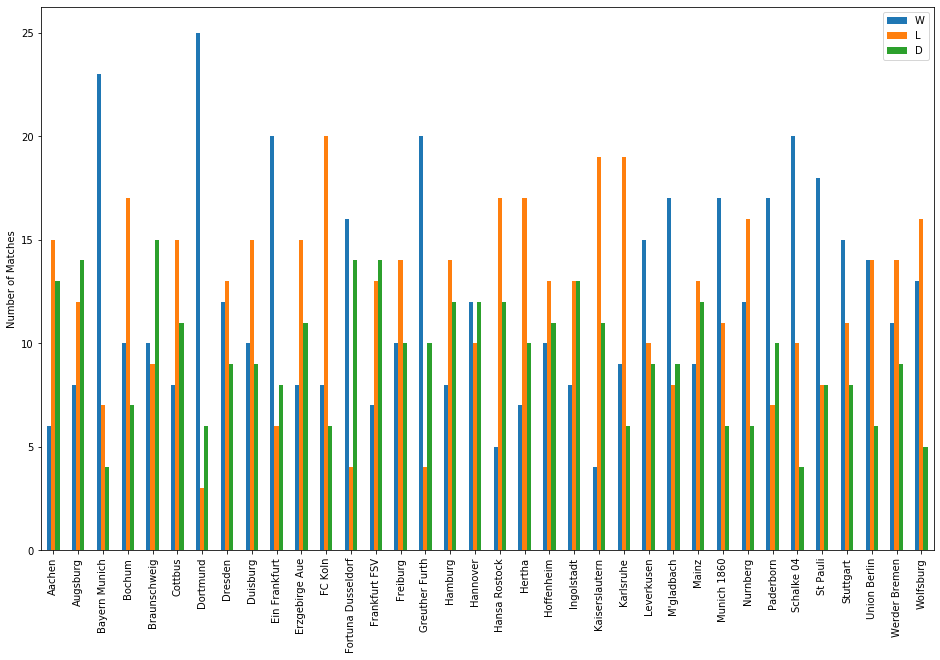

In [135]:
file_path = "/Users/ravimalde/dsc-files/student/Projects/football_weather_project/"
fig = plt.figure()
football_weather_hist = team_data.plot(x='TeamName', y=['W','L','D'], kind='bar', figsize=(16,10))
plt.xlabel('')
plt.ylabel('Number of Matches')
plt.savefig(file_path + "football_weather_hist.png")

In [136]:
# plt.figure(figsize = (16,10))
# plt.bar(data = team_data, x=team_data.TeamName, height= team_data['D'], color='blue')
# plt.xticks(rotation = 'vertical')
# plt.show()

In [137]:
# plt.figure(figsize = (16,10))
# plt.bar(data = team_data, x=team_data.TeamName, height= team_data['W'], color='green')
# plt.xticks(rotation = 'vertical')
# plt.show()

In [138]:
# plt.figure(figsize = (16,10))
# plt.bar(data = team_data, x=team_data.TeamName, height= team_data['L'], color='orange')
# plt.xticks(rotation = 'vertical')
# plt.yticks()
# plt.show()

# 5. STORING IN MONGODB

The cell below converts the team_data dataframe into a dictionary.

In [139]:
team_data_dict = team_data.to_dict(orient = 'records')
# team_data_dict =team_data_dict[0]

Next we connect to the mongodb server and crate a new collection within which we upload the team_data_dict dictionary.

In [140]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
mydb = myclient['football_weather_results']
mycollection = mydb['football_weather_results']
results = mycollection.insert_many(team_data_dict)
results

The football_weather_histogram must be converted into bytes in order to be uploaded to the mongodb server. It is then placed within a dictionary alongside a description so that it is easy to determine what the string is.

In [141]:
with open("football_weather_hist.png", "rb") as imageFile:
    football_weather_hist_byte = base64.b64encode(imageFile.read())

histogram_dict = {'Description': "A histogram of each teams' wins, draws and losses for the 2011 season", 
                                          'Image': football_weather_hist_byte}
results = mycollection.insert_one(histogram_dict)
results

Lastly, the cell below is a mongodb query that returns all of the contents of the collection. It is then checked to see if all of the desired contents have been successfully uploaded.

In [142]:
query_1 = mycollection.find({})
for document in query_1:
    print(document)

{'_id': ObjectId('5e342cb759ecee419e3592a9'), 'TeamName': 'Aachen', 'Total Goals Scored (2011 Season)': 30.0, 'D': 13, 'L': 15, 'W': 6, 'Win % on Rainy Days': 28.6}
{'_id': ObjectId('5e34344859ecee419e3592ad'), 'TeamName': 'Aachen', 'Total Goals Scored (2011 Season)': 30.0, 'D': 13, 'L': 15, 'W': 6, 'Win % on Rainy Days': 28.6}
{'_id': ObjectId('5e34378859ecee419e3592b2'), 'TeamName': 'Aachen', 'Total Goals Scored (2011 Season)': 30.0, 'D': 13, 'L': 15, 'W': 6, 'Win % on Rainy Days': 28.6}
{'_id': ObjectId('5e34378859ecee419e3592b3'), 'TeamName': 'Augsburg', 'Total Goals Scored (2011 Season)': 36.0, 'D': 14, 'L': 12, 'W': 8, 'Win % on Rainy Days': 50.0}
{'_id': ObjectId('5e34378859ecee419e3592b4'), 'TeamName': 'Bayern Munich', 'Total Goals Scored (2011 Season)': 77.0, 'D': 4, 'L': 7, 'W': 23, 'Win % on Rainy Days': 71.4}
{'_id': ObjectId('5e34378859ecee419e3592b5'), 'TeamName': 'Bochum', 'Total Goals Scored (2011 Season)': 41.0, 'D': 7, 'L': 17, 'W': 10, 'Win % on Rainy Days': 25.0}
{'